In [1]:
import os
import getpass
import numpy as np
import pandas as pd
from time import time
from functools import reduce
import matplotlib.pyplot as plt

# Sklearn
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Own lasso Liberay
import lasso_model 

# Lasso to Forecast Inflation

## Data processing

In [4]:
# Gå et niveau op og naviger til mappen "Data"
os.chdir('../Data')

### 1. Load data

In [6]:
# Import features
file_path = 'Merged_dataset.csv'
df = pd.read_csv("merged_dataset.csv", sep=";", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df.shape

(156, 184)

In [7]:
y = df.iloc[:, 0]   # første kolonne = inflation
X = df.iloc[:, 1:]  # resten = forklarende variable

# Tjek dimensioner
print("y shape:", y.shape)
print("X shape:", X.shape)

y shape: (156,)
X shape: (156, 183)


### 2. Imputer manglende værdier

In [9]:
imputer = SimpleImputer(strategy="median")  # Eller "median"

X_imputed = imputer.fit_transform(X)  # Imputer NaN i hele datasættet

# Konverter tilbage til DataFrame med kolonnenavne
X = pd.DataFrame(X_imputed, columns=X.columns, index = df.index)

### 3. Standardiser data 

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Forecast

In [13]:
def lasso_forecast(X, y, forecast_horizon, scaler, last_observation_date):
    """
    Træner en LASSO-model til forecasting og forudsiger inflation op til forecast_horizon måneder frem.
    
    Parametre:
        X: pd.DataFrame – features
        y: pd.Series – target (inflation)
        last_observation_date: str – f.eks. '2024-12-01'
        forecast_horizon: int – antal måneder frem
        plot: bool – om der skal vises plot
    
    Returnerer:
        forecast_df: pd.DataFrame med datoer og forudsagte værdier
    """

    # 1. Split data
    X = X.loc[:last_observation_date]
    y = y.loc[:last_observation_date]
    
    X_scaled = scaler.transform(X)

    
    # 2. Træn modeller for 1 til forecast_horizon måneder frem
    lasso_models = {}

    #for h in range(1, forecast_horizon + 1):
    for h in range(0, forecast_horizon):
        print(f"\n=== Horizon {h} ===")

        y_shifted = y.shift(-h)
        y_shifted = y_shifted.dropna()
     
        #X_train = X[:len(y_shifted), :]
        X_train = X_scaled[:len(y_shifted)]

        y_train = y_shifted
        
        #print(y_shifted)
        
        tscv = TimeSeriesSplit(n_splits=4)
        alphas = np.logspace(-4, 1, 100)  # Fra 0.0001 til 10
        model = LassoCV(alphas=alphas, cv=tscv, max_iter=100000)

    
        #model = LassoCV(cv=tscv, random_state=42, max_iter=100000)
        #model = LassoCV(cv=5, random_state=42, max_iter=100000)
        #model.fit(X_train, y_train)
        model.fit(X_train, y_train)
        lasso_models[h] = model
        
        coef = model.coef_
        print(f"Antal træningsobservationer: {len(y_train)}")
        print(f"Valgt alpha: {model.alpha_:.5f}")
        print(f"0-koeff = {np.sum(coef == 0)}, ≠0-koeff = {np.sum(coef != 0)}")
    
    # 3. Forudsig fremtiden
    X_t = X.loc[[last_observation_date]]
    X_t_scaled = scaler.transform(X_t)

    
    forecasts = {}
    for h in range(0, forecast_horizon):
        forecast_value = lasso_models[h].predict(X_t_scaled)
        forecasts[h] = forecast_value[0]

    # 4. Datoetiketter
    start_date = pd.to_datetime(last_observation_date) + pd.DateOffset(months=1)
    forecast_dates = [start_date + pd.DateOffset(months=h) for h in forecasts.keys()]

    # 👇 Print datoer for de forudsagte måneder
    print("\nForudsagte måneder:")
    for date in forecast_dates:
        print(date.strftime("%Y-%m"))
        
        
    forecast_df = pd.DataFrame({
        "Dato": forecast_dates,
        "Inflationsforecast": list(forecasts.values()),
        "Horizon": list(forecasts.keys())
    })
   
    return forecast_df


In [14]:
forecast_horizon = 5
%time forecast_df = lasso_forecast(X, y, forecast_horizon, scaler, last_observation_date="2024-12-01")


=== Horizon 0 ===
Antal træningsobservationer: 156
Valgt alpha: 0.00010
0-koeff = 139, ≠0-koeff = 44

=== Horizon 1 ===
Antal træningsobservationer: 155
Valgt alpha: 0.00231
0-koeff = 128, ≠0-koeff = 55

=== Horizon 2 ===
Antal træningsobservationer: 154
Valgt alpha: 0.07565
0-koeff = 167, ≠0-koeff = 16

=== Horizon 3 ===
Antal træningsobservationer: 153
Valgt alpha: 0.17074
0-koeff = 171, ≠0-koeff = 12

=== Horizon 4 ===
Antal træningsobservationer: 152
Valgt alpha: 0.15199
0-koeff = 166, ≠0-koeff = 17

Forudsagte måneder:
2025-01
2025-02
2025-03
2025-04
2025-05
CPU times: user 2min 38s, sys: 6min 50s, total: 9min 28s
Wall time: 58.9 s


In [15]:
forecast_df

,Dato,Inflationsforecast,Horizon
0,2025-01-01,1.882114,0
1,2025-02-01,2.359884,1
2,2025-03-01,2.309951,2
3,2025-04-01,2.191872,3
4,2025-05-01,2.507632,4


# rolling

In [17]:
def lasso_forecast_rolling(X, y, forecast_horizon, last_observation_date, scaler, window_length=108, verbose=True):
    """
    Forecast inflation using one Random Forest model per horizon (direct forecast), based on Garcia et al. (2017)
    
    Args:
        X: DataFrame of predictors
        y: Series of target variable
        forecast_horizon: int, how many steps ahead to forecast (e.g. 12)
        last_observation_date: str or Timestamp, end of training data and point of forecast
        scaler: a fitted sklearn scaler (no data leakage!)
        window_length: int, number of time steps in rolling window (default 108 = 9 years of monthly data)
    """

    # 1. Begræns datasættet til kun at inkludere real-time tilgængelige observationer (op til last_observation_date)
    X = X.loc[:last_observation_date]
    y = y.loc[:last_observation_date]

    # 2. Definér rolling window
    if len(X) < window_length:
        raise ValueError("Not enough data for the chosen rolling window length.")
    
    X_window = X.iloc[-window_length:]
    y_window = y.iloc[-window_length:]

    # 3. Træn en model per horisont (direct forecast approach)
    lasso_models = {}

    for h in range(forecast_horizon):
        if verbose: 
            print(f"\n=== Horisont h={h+1} ===")
        
        # Laver y_{t+h}
        y_shifted = y_window.shift(-h).dropna()

        # Matcher X til y
        X_train = X_window.iloc[:len(y_shifted)]
        y_train = y_shifted
        
        tscv = TimeSeriesSplit(n_splits=4)
        alphas = np.logspace(-4, 1, 100)  # Fra 0.0001 til 10
        model = LassoCV(alphas=alphas, cv=tscv, max_iter=100000)

        model.fit(scaler.transform(X_train), y_train)

        lasso_models[h] = model

        #coef = model.coef_
      
        if verbose: 
            print(f"Antal træningsobservationer: {len(y_train)}")
            print(f"Valgt alpha: {model.alpha_:.5f}")
            print(f"0-koeff = {np.sum(model.coef_ == 0)}, ≠0-koeff = {np.sum(model.coef_ != 0)}")
            

    # 4. Lav forecast fra X_t (real-time available data)
    X_t = X.loc[[last_observation_date]]  # Real-time input
    X_t_scaled = scaler.transform(X_t)

    lasso_forecasts = {}

    for h in range(forecast_horizon):
        forecast = lasso_models[h].predict(X_t_scaled)
        lasso_forecasts[h] = forecast[0]  # Gem som float

    # 5. Generér datoer
    start_date = pd.to_datetime(last_observation_date) + pd.DateOffset(months=1)
    forecast_dates = [start_date + pd.DateOffset(months=h) for h in lasso_forecasts.keys()]

    forecast_df = pd.DataFrame({
        "Dato": forecast_dates,
        "Inflationsforecast": list(lasso_forecasts.values()),
        "Horizon": list(lasso_forecasts.keys())
    })

    if verbose: 
        print("\nForudsagte måneder:")
        for date in forecast_dates:
            print(date.strftime("%Y-%m"))

    return forecast_df

In [18]:
forecast_horizon = 3 # 1 year
window_length = 9*12 # 12 Years
last_observation_date = "2024-12-01"

%time forecast_df = lasso_forecast_rolling(X, y, forecast_horizon, last_observation_date, scaler, window_length, verbose = True)


=== Horisont h=1 ===
Antal træningsobservationer: 108
Valgt alpha: 0.00036
0-koeff = 137, ≠0-koeff = 46

=== Horisont h=2 ===
Antal træningsobservationer: 107
Valgt alpha: 0.00327
0-koeff = 132, ≠0-koeff = 51

=== Horisont h=3 ===
Antal træningsobservationer: 106
Valgt alpha: 0.00115
0-koeff = 119, ≠0-koeff = 64

Forudsagte måneder:
2025-01
2025-02
2025-03
CPU times: user 17.9 s, sys: 54.5 s, total: 1min 12s
Wall time: 7.4 s


In [19]:
forecast_df

,Dato,Inflationsforecast,Horizon
0,2025-01-01,1.874613,0
1,2025-02-01,2.076937,1
2,2025-03-01,1.947104,2


# Rolling Forecast

In [21]:
def run_rolling_forecast(X, y, forecast_horizon=12, start_date="2012-01", end_date="2015-12", window_length=72):
    """
    Kører rolling real-time forecast med Random Forest, én forecast per måned (med 12 horisonter per gang)
    """

    all_forecasts = []

    forecast_dates = pd.date_range(start=start_date, end=end_date, freq="MS")

    for date in forecast_dates:
        print(f"\n=== Forecast lavet i: {date.strftime('%Y-%m')} ===")

        # Real-time datasæt
        X_train = X.loc[:date]
        y_train = y.loc[:date]

        if len(X_train) < window_length:
            print("Springer over pga. for lidt data.")
            continue

        # Skaler træningsdata (rolling window)
        scaler = StandardScaler()
        scaler.fit(X_train.iloc[-window_length:])

        # Lav forecast for 12 horisonter
        forecast_df = lasso_forecast_rolling(
            X=X,
            y=y,
            forecast_horizon=forecast_horizon,
            last_observation_date=date,
            scaler=scaler,
            window_length=window_length, 
            verbose=False
        )

        forecast_df["Forecast_made_in"] = date  # hvornår forecast blev lavet
        all_forecasts.append(forecast_df)

    all_forecasts_df = pd.concat(all_forecasts, ignore_index=True)
    return all_forecasts_df

In [22]:
forecast_results = run_rolling_forecast(X, y, forecast_horizon=12, start_date="2022-01", end_date="2024-12")


=== Forecast lavet i: 2022-01 ===

=== Forecast lavet i: 2022-02 ===

=== Forecast lavet i: 2022-03 ===

=== Forecast lavet i: 2022-04 ===

=== Forecast lavet i: 2022-05 ===

=== Forecast lavet i: 2022-06 ===

=== Forecast lavet i: 2022-07 ===

=== Forecast lavet i: 2022-08 ===

=== Forecast lavet i: 2022-09 ===

=== Forecast lavet i: 2022-10 ===

=== Forecast lavet i: 2022-11 ===

=== Forecast lavet i: 2022-12 ===

=== Forecast lavet i: 2023-01 ===

=== Forecast lavet i: 2023-02 ===

=== Forecast lavet i: 2023-03 ===

=== Forecast lavet i: 2023-04 ===

=== Forecast lavet i: 2023-05 ===

=== Forecast lavet i: 2023-06 ===

=== Forecast lavet i: 2023-07 ===

=== Forecast lavet i: 2023-08 ===

=== Forecast lavet i: 2023-09 ===

=== Forecast lavet i: 2023-10 ===

=== Forecast lavet i: 2023-11 ===

=== Forecast lavet i: 2023-12 ===

=== Forecast lavet i: 2024-01 ===

=== Forecast lavet i: 2024-02 ===

=== Forecast lavet i: 2024-03 ===

=== Forecast lavet i: 2024-04 ===

=== Forecast lavet 

In [38]:
forecast_results

,Dato,Inflationsforecast,Horizon,Forecast_made_in
0,2022-02-01,4.343565,0,2022-01-01
1,2022-03-01,5.844629,1,2022-01-01
2,2022-04-01,1.419554,2,2022-01-01
3,2022-05-01,0.177042,3,2022-01-01
4,2022-06-01,-0.368205,4,2022-01-01
...,...,...,...,...
427,2025-08-01,1.679396,7,2024-12-01
428,2025-09-01,0.501083,8,2024-12-01
429,2025-10-01,0.425766,9,2024-12-01
430,2025-11-01,0.524068,10,2024-12-01


In [41]:
def evaluate_forecasts(forecast_df, y):
    """
    Matcher forecast med y_true og returnerer RMSE og MAE pr. horisont
    """
    # Merge forecast og faktisk inflation
    merged = forecast_df.merge(
        y.rename("y_true"), 
        left_on="Dato", 
        right_index=True,
        how="left"
    )

    # Filtrer ud fremtid hvor vi ikke har faktisk inflation
    merged = merged.dropna(subset=["y_true"])

    # Beregn fejl
    merged["error"] = merged["Inflationsforecast"] - merged["y_true"]
    merged["abs_error"] = merged["error"].abs()
    merged["squared_error"] = merged["error"] ** 2

    # Evaluer pr. horisont
    evaluation = merged.groupby("Horizon").agg(
        MAE=("abs_error", "mean"),
        RMSE=("squared_error", lambda x: (x.mean())**0.5),
        N_obs=("y_true", "count")
    ).reset_index()

    return evaluation, merged


In [44]:
eval_df, merged_df = evaluate_forecasts(forecast_results, y)
eval_df

,Horizon,MAE,RMSE,N_obs
0,0,0.645929,0.835664,35
1,1,1.459686,2.197017,34
2,2,2.138257,2.849978,33
3,3,2.859477,3.908969,32
4,4,3.590124,4.672821,31
5,5,3.523899,4.716998,30
6,6,3.413739,4.453817,29
7,7,5.665699,8.076536,28
8,8,6.027057,8.354313,27
9,9,4.936067,6.062669,26


In [64]:
h1 = merged_df[merged_df["Horizon"] == 0]
h1

,Dato,Inflationsforecast,Horizon,Forecast_made_in,y_true,error,abs_error,squared_error
0,2022-02-01,4.343565,0,2022-01-01,4.798,-0.454435,0.454435,0.206511
12,2022-03-01,4.796439,0,2022-02-01,5.369,-0.572561,0.572561,0.327826
24,2022-04-01,5.366250,0,2022-03-01,6.686,-1.319750,1.319750,1.741740
36,2022-05-01,6.679023,0,2022-04-01,7.436,-0.756977,0.756977,0.573015
48,2022-06-01,7.423316,0,2022-05-01,8.190,-0.766684,0.766684,0.587804
60,2022-07-01,8.162899,0,2022-06-01,8.704,-0.541101,0.541101,0.292790
72,2022-08-01,8.705348,0,2022-07-01,8.910,-0.204652,0.204652,0.041882
84,2022-09-01,8.920423,0,2022-08-01,10.019,-1.098577,1.098577,1.206871
96,2022-10-01,10.004253,0,2022-09-01,10.112,-0.107747,0.107747,0.011609
108,2022-11-01,10.110870,0,2022-10-01,8.870,1.240870,1.240870,1.539759


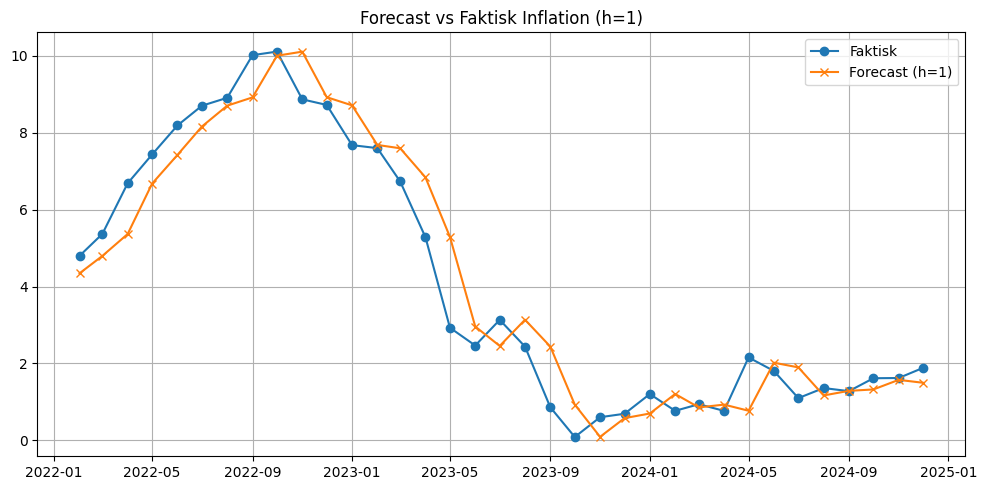

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(h1["Dato"], h1["y_true"], label="Faktisk", marker="o")
plt.plot(h1["Dato"], h1["Inflationsforecast"], label="Forecast (h=1)", marker="x")
plt.legend()
plt.title("Forecast vs Faktisk Inflation (h=1)")
plt.grid(True)
plt.tight_layout()
plt.show()